In [1]:
## MP 573 Lecture 28: N-D PSD
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy import signal
import pywt as wt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
import scipy.stats as stats
import statsmodels.api as sm

font = {'weight' : 'normal',
        'size'   : 14}

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

## Autocorrelation and PSD for iid noise


Example image with Gaussian iid noise

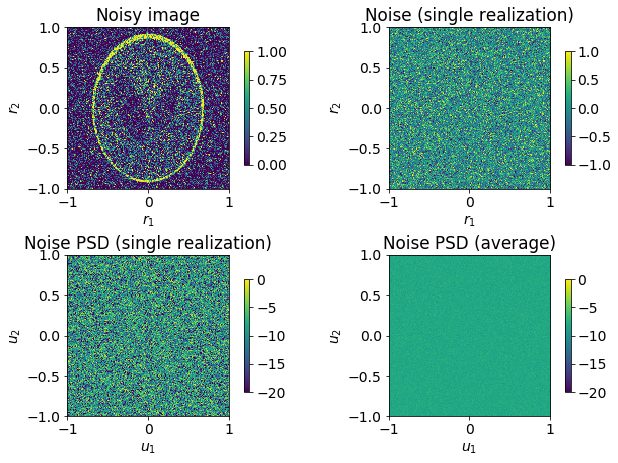

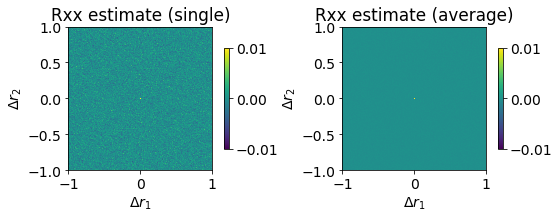

In [2]:
# Simulate noiseless image
f = shepp_logan_phantom()
f = rescale(f, scale=0.4)
size1,size2 = f.shape

# Add iid Gaussian noise
std = 0.4
Nr = 100
x = np.random.normal(0,std,[size1,size2,Nr])
x1 = x[:,:,0] # Grab the first realization of the noise
fn = f + x1

# Calculate the PSD of this noise realization
x1hat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x1)));
psd_x1 = 1/(size1*size2)*np.abs(x1hat)**2

# Calculate the PSD across multiple noise realizations
xhat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x,axes=[0,1]),axes=[0,1]),axes=[0,1]);
psd_x = 1/(size1*size2)*np.mean(np.abs(xhat)**2,axis=2)

# Calculate the Rxx from our 'single-realization' and 'multi-realization' estimates
Rxx1 = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(psd_x1))));
Rxx = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(psd_x))));



# Display
plt.figure(figsize=(9,9))
plt.rc('font', **font)
plt.subplot(3,2,1)
plt.imshow(fn,vmin=0,vmax=1,extent = [-1,1,-1,1])
plt.title('Noisy image')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.subplot(3,2,2)
plt.imshow(x1,vmin=-1,vmax=1,extent = [-1,1,-1,1])
plt.title('Noise (single realization)')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.subplot(3,2,3)
plt.imshow(10*np.log10(psd_x1),vmin=-20,vmax=0,extent = [-1,1,-1,1]);
plt.title('Noise PSD (single realization)')
plt.colorbar(shrink=0.7);
plt.xlabel('$u_1$');plt.ylabel('$u_2$');
plt.subplot(3,2,4)
plt.imshow(10*np.log10(psd_x),vmin=-20,vmax=0,extent = [-1,1,-1,1]);
plt.title('Noise PSD (average)');
plt.tight_layout(pad=0.4)
plt.colorbar(shrink=0.7);
plt.xlabel('$u_1$');plt.ylabel('$u_2$');
plt.figure(figsize=(9,9))
plt.rc('font', **font)
plt.subplot(3,2,5)
plt.imshow(Rxx1,vmin=-0.01,vmax=0.01,extent = [-1,1,-1,1])
plt.title('Rxx estimate (single)')
plt.colorbar(shrink=0.7);
plt.xlabel('$\Delta r_1$');plt.ylabel('$\Delta r_2$');
plt.subplot(3,2,6)
plt.imshow(Rxx,vmin=-0.01,vmax=0.01,extent = [-1,1,-1,1])
plt.title('Rxx estimate (average)')
plt.colorbar(shrink=0.7);
plt.xlabel('$\Delta r_1$');plt.ylabel('$\Delta r_2$');


## Low-pass filtered noise

Here we take the previous image with iid Gaussian noise, 
and filter it with a low-pass filter

In [ ]:
# Now let us filter the image (and the noise)
r1 = np.linspace(-1,1,size1)
r1,r2 = np.meshgrid(r1,r1)
h =  1.0*(np.abs(r1)<=0.05)*(np.abs(r2)<=0.05) # Low pass filter 
h = h/np.sum(np.abs(h))
gn = signal.fftconvolve(h, fn, mode='same') 
y1 = signal.fftconvolve(h, x1, mode='same') 

# Calculate the PSD of this noise realization
y1hat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(y1)));
psd_y1 = 1/(size1*size2)*np.abs(y1hat)**2

# Calculate the PSD across multiple noise realizations
y = 0*x;
for k in range(Nr):
    y[:,:,k] = signal.fftconvolve(h, x[:,:,k], mode='same') 
yhat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(y,axes=[0,1]),axes=[0,1]),axes=[0,1]);
psd_y = 1/(size1*size2)*np.mean(np.abs(yhat)**2,axis=2)


# Calculate the Rxx from our 'single-realization' and 'multi-realization' estimates
Ryy1 = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(psd_y1))));
Ryy = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(psd_y))));





# Display
plt.figure(figsize=(9,9))
plt.rc('font', **font)
plt.subplot(3,2,1)
plt.imshow(gn,vmin=0,vmax=1,extent = [-1,1,-1,1])
plt.title('Noisy image')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.subplot(3,2,2)
plt.imshow(y1,vmin=-1,vmax=1,extent = [-1,1,-1,1])
plt.title('Noise (single realization)')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.subplot(3,2,3)
plt.imshow(10*np.log10(psd_y1),vmin=-20,vmax=0,extent = [-1,1,-1,1]);
plt.title('Noise PSD (single realization)')
plt.colorbar(shrink=0.7);
plt.xlabel('$u_1$');plt.ylabel('$u_2$');
plt.subplot(3,2,4)
plt.imshow(10*np.log10(psd_y),vmin=-20,vmax=0,extent = [-1,1,-1,1]);
plt.title('Noise PSD (average)');
plt.tight_layout(pad=0.4)
plt.colorbar(shrink=0.7);
plt.xlabel('$u_1$');plt.ylabel('$u_2$');
plt.subplot(3,2,5)
plt.imshow(Ryy1,vmin=-0.002,vmax=0.002,extent = [-1,1,-1,1])
plt.title('Ryy estimate (single)')
plt.colorbar(shrink=0.7);
plt.xlabel('$\Delta r_1$');plt.ylabel('$\Delta r_2$');
plt.subplot(3,2,6)
plt.imshow(Ryy,vmin=-0.002,vmax=0.002,extent = [-1,1,-1,1])
plt.title('Ryy estimate (average)')
plt.colorbar(shrink=0.7);
plt.xlabel('$\Delta r_1$');plt.ylabel('$\Delta r_2$');

## Reconstruction from projection data

### Generation of noisy data

Let us simulate some projection data, with Gaussian noise (for simplicity)


In [ ]:
#Here's the data
data_dir = pjoin('.', 'data')
xtrue = shepp_logan_phantom()
xtrue = rescale(xtrue, scale=0.4, multichannel=False)
N1,N2 = xtrue.shape
theta = np.linspace(0.5, 179.5, 180, endpoint=True)
data = radon(xtrue, theta=theta, circle=False)
M1,M2 = data.shape

# Add iid Gaussian noise
std = 4
Nr = 100
x = np.random.normal(0,std,[M1,M2,Nr])
x1 = x[:,:,0] # Grab the first realization of the noise
datan = data + x1

#plt.figure(figsize=(4,4))
#imgplot = plt.imshow(abs(np.reshape(xtrue,(N1,N2))),cmap='gray',vmin=0,vmax=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("True image")
ax1.imshow(xtrue, vmin=0, vmax=1,extent = [-1,1,-1,1])
ax2.set_title("Noisy data (sinogram)")
ax2.imshow(datan, vmin=0, vmax=50, aspect='auto',extent = [-1,1,-1,1]);



### Filtered back-projection based image reconstruction

Next, we reconstruct the image from the noisy projection data using a filtered backprojection

In [ ]:
# Filtered backprojection
filtertype = 'cosine' # ramp, shepp-logan, cosine, hamming, hann, None
im1 = iradon(datan, theta=theta, circle=False, filter=filtertype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.imshow(im1,vmin=0,vmax=1,extent = [-1,1,-1,1])
ax1.set_title('Direct (FBP) recon')

y1 = iradon(x1, theta=theta, circle=False, filter=filtertype)
#ax2.imshow(y1,vmin=-0.5,vmax=0.5,extent = [-1,1,-1,1])
#ax2.set_title('Reconstructed image noise')

y1hat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(y1)));
psd_y1 = 1/(N1*N2)*np.abs(y1hat)**2
ax2.imshow(10*np.log10(psd_y1),vmin=-30,vmax=-10,extent = [-1,1,-1,1])
ax2.set_title('Image noise PSD (1 realization)')

# Calculate the PSD across multiple noise realizations
y = np.zeros((N1,N2,Nr));
for k in range(Nr):
    y[:,:,k] = iradon(x[:,:,k], theta=theta, circle=False, filter=filtertype)
yhat = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(y,axes=[0,1]),axes=[0,1]),axes=[0,1]);
psd_y = 1/(size1*size2)*np.mean(np.abs(yhat)**2,axis=2)

# Calculate Ryy
Ryy = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(psd_y))));

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.imshow(10*np.log10(psd_y),vmin=-30,vmax=-10,extent = [-1,1,-1,1])
ax1.set_title('Image noise PSD (average)');


ax2.imshow(Ryy,vmin=-0.01,vmax=0.01,extent = [-1,1,-1,1])
ax2.set_title('Image noise Ryy (average)');



